# 2D Relaxation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg

The techniques for doing relaxation that you've learned over the last two notebooks generalize nicely to two-dimensions (2D). Further generalization to higher dimensions then proceeds similarly. 

## Physical Setup

For some time we will focus on numerically solving a single physical problem. In electrostatics the easiest way to realize this problem is with an idealized three-dimensional setup, however the symmetry along the $z$-axis will make it so that we really only need to solve a 2D problem. 

The setup is as follows: Three infinitely-long grounded metal plates, at $x=0$, $x=1$ and $y = 0$, are connected at $y = 1$ by a metal strip maintained at a  potential $V(x,y=1) = \sin(\pi x)$ (a thin layer of insulation at each corner prevents them from shorting out). Find the potential inside the resulting rectangular pipe. The equation that dictates the potential is the 2D Laplace equation, to which we now turn.


## The Laplace Equation in 2D

The 2D Laplace equation is 

$$
\nabla^2 V = \frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2} = 0.
$$

Just as in 1D, this equation can be discretized by returning to the definition of the partial derivatives $\partial/\partial x$ and $\partial/\partial y$. However, in this case it is useful to allow yourself to have different step sizes in the $x$- and in the $y$-directions. To this end, instead of using $h$ to indicate a numerical step size, let $\Delta x$ represent a single step in the $x$-direction and similarly for $\Delta y$.  In the numerics below we will often give these step sizes the same value, e.g. $\Delta x = \Delta y =1$, but by setting the calculation up this way, you are free not to. 

As before, it is also useful to setup a shorthand for the potential evaluated on a lattice point. In 2D a given lattice point will have $x$ and $y$ coordinates. Define these coordinates to be $x_i$ and $y_j$, where the subscript $i$ means that $x_i$ is $i$ steps to the right of the origin, and with $i$ and $j$ both integers. In other words $x_i = i\cdot \Delta x$. Similarly, $y_j = j \cdot \Delta y$ is $j$ steps above the origin. Finally, we define the potential $V$ at the lattice point $(x_i, y_j)$ to be $V(x_i, y_j) \equiv V_{i,j}$. The comma in the subscript of $V_{i,j}$ simply acts to separate the $i$ and $j$ values.

<b>Exercise (a):</b> With the conventions just described, discretize $\nabla^2V$ and write out the discrete Laplace equation. [*Ans*:

$$
\frac{V_{i+1,j}-2V_{i,j}+V_{i-1,j}}{\Delta x^2} + \frac{V_{i,j+1}-2V_{i,j}+V_{i,j-1}}{\Delta y^2} =0.]
$$

## Constructing lattices in 2d

The conventions described above go a long way to describing 2D lattices, but we still need a way to represent them in Python. Visualizing the lattice will be invaluable as well. 

Fortunately, the NumPy meshgrid function, already introduced in the notebook on plotting vector fields, does a lot of the work for us. The vector field notebook took a 'black box' approach to meshgrid, using it without worrying much about understanding it. Here we will begin to better understand how this function works. 

The meshrid function works in any number of dimensions, but we will focus on the 2D case. In this case meshgrid accepts two arrays as inputs, treats them as lattices in the $x$ and $y$ directions, and returns a 2D lattice of points in the $xy$ plane. For example, if you supply the arrays [0,1,2] and [0,1,2] as inputs, then it returns two 3x3 arrays consisting of the $x$ and $y$ coordinates of the 9 points of the 2D lattice formed by the Cartesian product of the two input arrays. This is easier to see than to read:

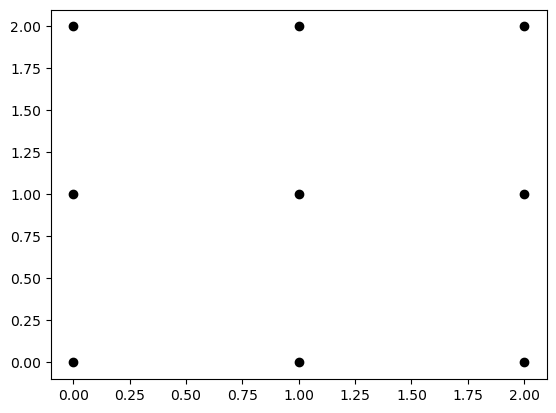

In [66]:
x,y = np.meshgrid(np.linspace(0,2,3),np.linspace(0,2,3))

fig, ax = plt.subplots() 
ax.plot(x,y,"ko") 
plt.show()

This example shows how well meshgrid and matplotlib fit together. And, once you've seen a picture of it, it is easier to parse out how Python does it. Printing out the two arrays yields:

In [42]:
x,y = np.meshgrid(np.linspace(0,2,3),np.linspace(0,2,3))
print(x)
print(y)

[[0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]]
[[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]]


The first array stores the $x$-coordinates of each row of points in the rows of an array, and similarly for $y$-coordinates in the 2nd array. In fact, by looking at the 2nd array, we can see that the first row of the array corresponds to the point lowest on the diagram, the 2nd row to the middle points, and the 3rd to the uppermost points. 

Implicit in these arrays, then, is a way of moving through the points of the lattice that we will use in our code too. The elements of the arrays begin with the lower left point of the lattice, move along the bottom row, from left to right, shift up to the middle row, proceed left to right again, and finally do the same along the uppermost row. Expressing this in terms of the potential $V_{i,j}$ of the last section, we begin with $V_{0,0}$, go to $V_{0,1}$ and $V_{0,2}$, then go to $V_{1,0}$, $V_{1,1}$, and $V_{1,2}$, and finally visit $V_{2,0}$, $V_{2,1}$, and $V_{2,2}$.  You may find it helpful to have the mental image of an arrow zig-zagging from one row of lattice points to the next, as in the plot below:

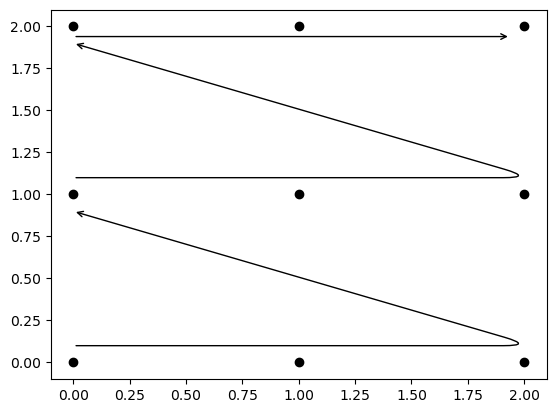

In [64]:
x,y = np.meshgrid(np.linspace(0,2,3),np.linspace(0,2,3))

fig, ax = plt.subplots() 
ax.plot(x,y,"ko") 

#The annotate command allows you to add things (arrows, text, etc) on top of a plot
ax.annotate("",
            xy=(0, 0.9), xycoords='data',
            xytext=(0, 0.1), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc,angleA=0,angleB=0,armA=460,armB=0,rad=30"))
ax.annotate("",
            xy=(0, 1.9), xycoords='data',
            xytext=(0, 1.1), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc,angleA=0,angleB=0,armA=460,armB=0,rad=30"))
ax.annotate("",
            xy=(1.94, 1.94), xycoords='data',
            xytext=(0, 1.94), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.show()

## Boundary Values in 2D

Before moving on to solving Laplace's equation in 2D, it is useful to think again about boundary values. As before we will focus on the simplest case, where boundary values are specified all the way around the boundary of the 2D region. These are called Dirichlet boundary conditions, and contrast with problems where you specify the derivative of the potential on one or more boundaries; the latter are called Neumann boundary conditions and will be taken up in a future notebook.

The figure below depicts a 5x5 lattice. Highlighted in blue are the internal lattice points, where the potential $V_{i,j}$ is completely unknown. In magenta, are boundary lattice points where the potential is given. In black, there is a set of corner lattice points, which you could consider 'boundary lattice points', but which won't come into any of the equations and, therefore, are easier to ignore. 

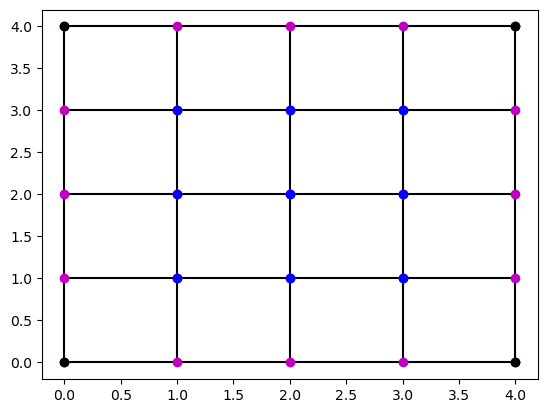

In [33]:
x,y = np.meshgrid(np.linspace(0,4,5),np.linspace(0,4,5))
xin, yin = np.meshgrid(np.linspace(1,3,3),np.linspace(1,3,3))
xc, yc = np.meshgrid(np.linspace(0,4,2),np.linspace(0,4,2))

fig, ax = plt.subplots() #Setup figure

ax.plot(x,y,"-k")
ax.plot(y,x,"-k")
ax.plot(x,y,"mo",xin,yin,"bo",xc,yc,"ko") #Make plot


plt.show()

These differences are useful to highlight, because, whether you use an iterative method or the linear algebra approach, in both cases you need to be aware that you are only trying to solve the potential at the blue points. At the other points the potential is either given or irrelevant. This determines how you define the loops in the iterative process, or the matrix you are trying to invert in the linear algebra case. 

In this notebook we will focus on the linear algebra approach.

## The Structure of the Linear Algebra Problem

If you stare at the lattice just depicted, you will notice that each of the nine blue points is different. Some of the points have two magenta neighbors, but others only have one or none. For some, the magenta neighbor is above and for others it is to the right. These differences change the structure of the linear algebra problem. 

To illustrate this, I'll figure out the discrete Laplace equation for $V_{3,2}$, that is for $i=3$ and $j=2$, in the case that $\Delta x = \Delta y$. Beginning with 

$$
\frac{V_{4,2}-2V_{3,2}+V_{2,2}}{\Delta x^2} + \frac{V_{3,3}-2V_{3,2}+V_{3,1}}{\Delta y^2} =0, 
$$

I multiply through by $\Delta x^2 = \Delta y^2$ and move the known $V_{4,2}$ to the right to get
 
$$
-4V_{3,2}+V_{2,2}+V_{3,3}+V_{3,1} = -V_{4,2}.
$$

Multiplying through by $-1$ (just to make the coefficient of the lattice point we are focusing on positive), this equation can be written in matrix form as 

$$
\begin{pmatrix}
0 & 0 & -1 & 0 & -1 & 4 & 0 & 0 & -1
\end{pmatrix}
\begin{pmatrix}
V_{1,1}\\ V_{2,1} \\ V_{3,1} \\ V_{1,2} \\ V_{2,2} \\ V_{3,2} \\ V_{1,3} \\ V_{2,3} \\ V_{3,3}
\end{pmatrix} = V_{4,2}.
$$

Several comments are in order: notice that the column vector of unknown potentials has length nine. This matches the fact that we don't know the potential at nine lattice points. Also note that the unknown potentials are ordered in the vector following the zig-zag arrows in the figure above. Of those nine unknowns, only four showed up in this equation and that is why only four of the numbers in the coefficient row vector are non-zero. The row vector has format 1x9 and the column vector has format 9x1 and so their product properly gives a matrix of format 1x1, in other words, a simple number. The fifth potential, in this case a known boundary value, appears on the right hand side of the equation.

Before trying to identify the pattern in general, write out a few more example equations:

<b> Exercise (b):</b> Take $\Delta x = \Delta y$ and consider the lattice depicted in the last subsection. Pick three lattice points and write out Laplace's equation for each of them. Simplify these equations until all the unknowns are on the left and all the known, boundary values, are on the right. 

<b> Exercise (c):</b> Using the example at the beginning of this section, your results from <b>(b)</b>, and the ordering of lattice points discussed in the section "Construcing lattices in 2d", write a code that constructs the matrix equation equivalent to Laplace's equation on the 5x5 lattice from the last section. This will include a 9x9 matrix. Rather than trying to write out all of the equations before you begin coding, use the insights you came to about the different kinds of lattice points in <b>(b)</b> to figure out the pattern you need to fill the matrix with. [Hint: If you have trouble identifying the matrix equation, or get stuck on how to code it up, I do the slightly more intricate 6x6 lattice as an example below.] Here you used a particular ordering of the lattice points. What would it change about the linear algebra formulation of the problem if you were to change that ordering? 

## Solving and Plotting Laplace's Equation on a 2D Lattice

Of course, the number of lattice points need have nothing to do with the extension of the space that we are chopping up. Below I construct a lattice with six evenly spaced points along each axis of a square with side length one:

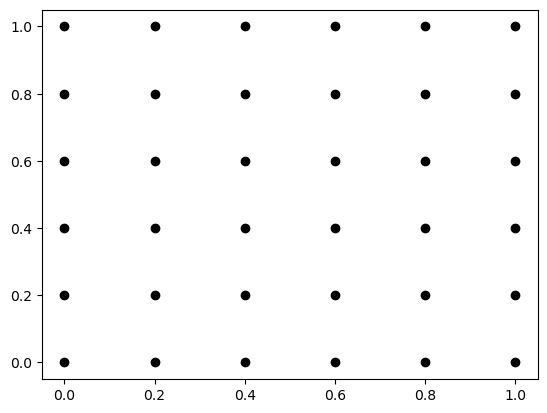

In [72]:
x,y = np.meshgrid(np.linspace(0,1,6),np.linspace(0,1,6))

fig, ax = plt.subplots() 
ax.plot(x,y,"ko") 
plt.show()

Let's solve Laplace's equation on this lattice with the following boundary conditions: (i) along three of the walls, those at $x=0$, $x=1$, and at $y=0$, the plate is grounded; and (ii) at $y=1$ the potential is $V(x,y=1)=\sin(\pi x)$.

First we use what we learned from <b>(c)</b> to setup the matrix equation, and then we solve it:

In [8]:
M = np.zeros([16,16])       #Initialize the matrix we will eventually need to invert
for i in range(16):         # Fill the entries properly:
    M[i, i] = 4             # Set the diagonals to 4.
    if i > 0:                # Begin by setting all the neighbors to the diagonals to -1.
        M[i, i-1] = -1       # This assumes that each lattice point has a neighbor to the 
    if i < 15:               # left and right, which is false and is corrected below.
        M[i, i+1] = -1
    if i > 3:               #Once you are far enough into the lattice, always include -1
        M[i,i-4] = -1       # for a lattice neighbor below the current site.
    if i < 12:              #As long you are not too far into the lattice, always include -1
        M[i,i+4] = -1       # for a lattice neighbor above the current site.

for i in range(4,13):      #For lattice sites neighboring the left and right boundaries 
    if i%4==0:             #remove the left (or right, respectively) neighbor. 
        M[i,i-1]=0         #Here, the % operator gives the value of i mod 4. Like a clock
        M[i-1,i]=0         # with only 0,1,2,3 on it, it returns 0 for any multiple of 4.
        
print(M)

b=np.zeros(16)                            # Initialize all boundary values to zero.
bndxs=np.linspace(0.2,0.8,4)              #Define x's along top boundary
b[12:16]=[np.sin(np.pi*x) for x in bndxs] #Update boundary V's along top boundary

print(b)

    
IntVals=linalg.inv(M)@b    #Solve for the internal potentials.
print(IntVals)

[[ 4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  4.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0. -1.  4.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  4. -1.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  4. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. 

The final output gives the electric potential at all of the internal points of the lattice. Our next step is to use this data to make a nice visualization of the result. In preparation, it is helpful to reshape the data so that instead of a long row of potential values, we have a clear correspondence between each potential value and a lattice point. The Python command reshape does exactly what we need, transforming a 1D array into a 2D array of specified shape:

In [193]:
IntValsMat = IntVals.reshape(4,4) #In order to recombine with the boundary values and for visualization,
                                  # reshape the solution to agree with the lattice shape.
print(IntValsMat)

VSol = np.zeros([6,6])     #Combine the solution and boundary values into one output
VSol[1:5,1:5]=IntValsMat
VSol[5,1:5]=b[12:16]    
print(VSol)

[[0.0363497  0.05881506 0.05881506 0.0363497 ]
 [0.08658376 0.14009547 0.14009547 0.08658376]
 [0.16988987 0.27488758 0.27488758 0.16988987]
 [0.31808813 0.51467741 0.51467741 0.31808813]]
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.0363497  0.05881506 0.05881506 0.0363497  0.        ]
 [0.         0.08658376 0.14009547 0.14009547 0.08658376 0.        ]
 [0.         0.16988987 0.27488758 0.27488758 0.16988987 0.        ]
 [0.         0.31808813 0.51467741 0.51467741 0.31808813 0.        ]
 [0.         0.58778525 0.95105652 0.95105652 0.58778525 0.        ]]


Finally, to visualize these data we will use a contour plot. The PyPlot library we have been using has a built-in countourf function. This function takes the points of the lattice, the potential above each point, and the number of contours as input. Here I have intentionally only plotted a few contours because I don't want to give the impression that we have solved the problem at more lattice points than we have.

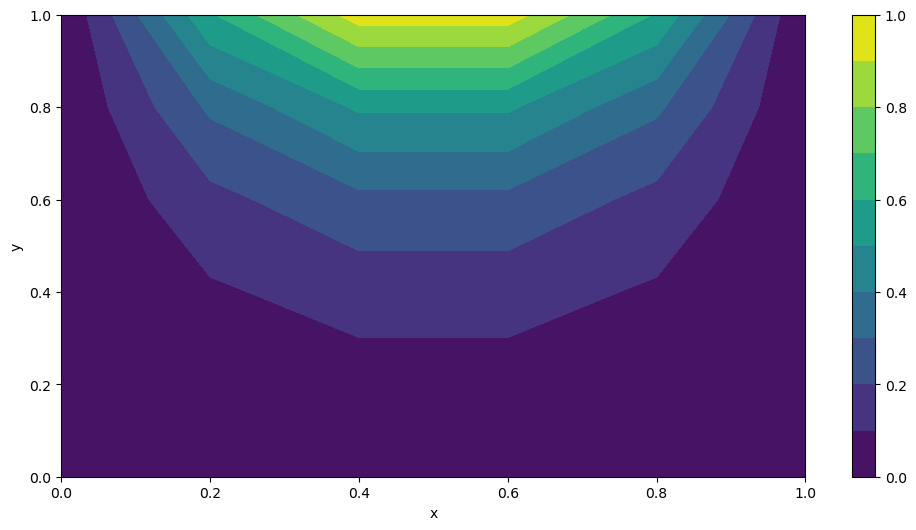

In [194]:
x,y = np.meshgrid(np.linspace(0,1,6),np.linspace(0,1,6))
plt.figure(figsize=(12, 6))
plt.contourf(x, y, VSol, 10)
plt.colorbar()
plt.ylabel('y')
plt.xlabel('x')
plt.show()

<b>Exercise (d):</b> Solve the matrix equation you setup in <b>(c)</b> and plot the potential, including boundary values, on a 2D contour plot. Use a small number of contours so as not to give the impression that you have found a more detailed solution than you have. If you wanted to give a higher resolution plot of the solution to this problem, what is the main ingredient in your code that you would need to change (pick just one)?